# StackOverflow Questions

My first (ever) StackOverflow question was unclear, so I created this Notebook to investigate the answer and try to refine the question. The question is: [Why would a scaled SVD run so much slower than an unscaled SVD in a random forest model?](https://stackoverflow.com/questions/65677406/why-would-a-scaled-svd-run-so-much-slower-than-an-unscaled-svd-in-a-random-fores/65678335#65678335)

It is interesting that as a consumer of StackOverflow I never noticed that the original question can be as long and informative as needed, but comments or follow ups are very limited for the author. This means the original question needs to be very focused and not meant to start a discussion around a topic. My question had several flaws and bad assumptions.

One bad assumption is that I needed to scale for Logistic Regression (which did help, and failed without scaling, but for reasons beyond this discussion). So I originally meant to use a `minmax_scaler` and not `MaxAbsScaler`. Secondly, I should've realized that there are many ways to answer my question without the reproducible steps and data to specifically answer it - and while reproducing the steps isn't impossible, it is certainly too much to expect from answerers. 

In the first set of plots below I (mostly) copied the code from the first answer which shows one way in which a model would have a hard time classifying data after scaling. The reason this is so, as far as I can tell, is because the data was scaled separately. 

In the second set of plots I try to reproduce my problem using the project's data and workflow, but reducing the dimensionality from 300 to 2 to be able to plot it in 2D. These plots show how the underlying data relationships do not change with scaling, only the scale itself.

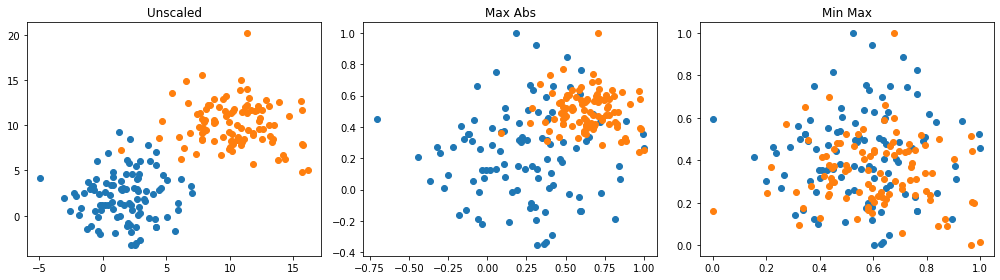

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler, minmax_scale

# for reproducibility
np.random.seed(42) 

# unscaled
std = 7
X = np.random.multivariate_normal([2, 2], [[std, 0], [0, std]], size=100)
Y = np.random.multivariate_normal([10, 10], [[std, 0], [0, std]], size=100)

# scaler 1
scaler_ = MaxAbsScaler()
X_maxabs = scaler_.fit_transform(X) # separate scaling for X and Y
Y_maxabs = scaler_.fit_transform(Y)

# scaler 2
X_norm = minmax_scale(X, feature_range=(0, 1), axis=0, copy=True)
Y_norm = minmax_scale(Y, feature_range=(0, 1), axis=0, copy=True)

# plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

axes[0].scatter(X[:, 0], X[:, 1])
axes[0].scatter(Y[:, 0], Y[:, 1])
axes[1].scatter(X_maxabs[:, 0], X_maxabs[:, 1])
axes[1].scatter(Y_maxabs[:, 0], Y_maxabs[:, 1])
axes[2].scatter(X_norm[:, 0], X_norm[:, 1])
axes[2].scatter(Y_norm[:, 0], Y_norm[:, 1])
axes[0].title.set_text('Unscaled')
axes[1].title.set_text('Max Abs')
axes[2].title.set_text('Min Max')

fig.tight_layout()

# Singular Vector Decomposition

---


### Setup

In [2]:
import os
import time
import json

import numpy as np
import pandas as pd

from datetime import datetime

start_time = time.time()
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-01-14


### Load Data

In [3]:
def load_data(data):
    raw_path = os.path.join("data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

# transform y_array into int type
y_train[y_train=='ham'] = 0
y_train[y_train=='spam'] = 1
y_train = y_train.astype('int')

### BoW and Tfidf

Here I clean and preprocess the data in two formats, a Bag-of-upto-Trigrams with 2,000 terms, and a Tfidf representation of the same.

In [4]:
import urlextract
from nltk.stem import WordNetLemmatizer

with open("contractions_map.json") as f:
    contractions_map = json.load(f)

url_extractor = urlextract.URLExtract()
lemmatizer = WordNetLemmatizer()

import custom.clean_preprocess as cp

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline([('counter', cp.DocumentToNgramCounterTransformer(n_grams=3)),
                 ('bot', cp.WordCounterToVectorTransformer(vocabulary_size=2000)),
                 ('tfidf', TfidfTransformer(sublinear_tf=True))          
                ])

In [5]:
# Bag-of-Trigrams
X_trans_counter = pipe['counter'].fit_transform(X_train)
X_trans_bot = pipe['bot'].fit_transform(X_trans_counter)

# Tfidf
X_trans_tfidf = pipe.fit_transform(X_train)

### SVD


In [6]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip
from sklearn.preprocessing import MaxAbsScaler, minmax_scale

def perform_SVD(X, n_components=300):

    # transpose to a term-document matrix
    U, Sigma, VT = svds(X.asfptype().T, 
                        k=n_components)
    # reverse outputs
    Sigma = Sigma[::-1]
    U, VT = svd_flip(U[:, ::-1], VT[::-1])
    
    # transpose to get V
    V = VT.T
    
    # max abs scales so that the max val is 1
    # includes negative values though
    scaler = MaxAbsScaler()
    X_maxabs = scaler.fit_transform(V) 
    # min max scale fits the data between two vals, 0 and 1 in this case
    X_minmax = minmax_scale(V, feature_range=(0, 1), axis=0, copy=True)
    
    return V, X_maxabs, X_minmax

In [7]:
X_svd, X_maxabs, X_minmax = perform_SVD(X_trans_tfidf)

We end up with matrices that are 3,900 long and 300 wide:

In [8]:
svd_data = {'V1':X_svd.T[0], 'V2':X_svd.T[1], 'y':y_train}
X_svd_df = pd.DataFrame(svd_data)

maxabs_data = {'V1':X_maxabs.T[0], 'V2':X_maxabs.T[1], 'y':y_train}
X_maxabs_df = pd.DataFrame(maxabs_data)

minmax_data = {'V1':X_minmax.T[0], 'V2':X_minmax.T[1], 'y':y_train}
X_minmax_df = pd.DataFrame(minmax_data)

## Scatter plot of first couple features

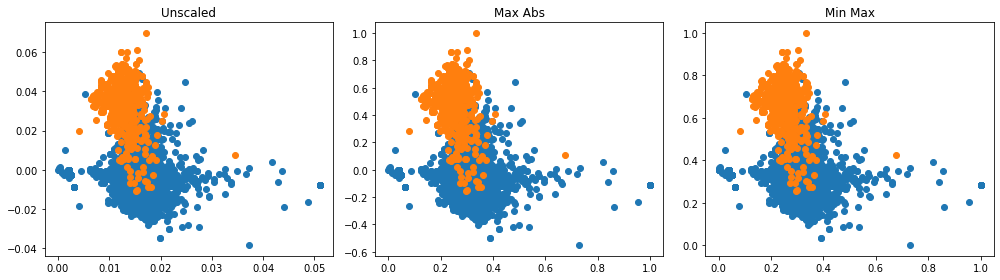

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

axes[0].scatter(X_svd_df['V1'][X_svd_df['y']==0], X_svd_df['V2'][X_svd_df['y']==0])
axes[0].scatter(X_svd_df['V1'][X_svd_df['y']==1], X_svd_df['V2'][X_svd_df['y']==1])

axes[1].scatter(X_maxabs_df['V1'][X_maxabs_df['y']==0], X_maxabs_df['V2'][X_maxabs_df['y']==0])
axes[1].scatter(X_maxabs_df['V1'][X_maxabs_df['y']==1], X_maxabs_df['V2'][X_maxabs_df['y']==1])

axes[2].scatter(X_minmax_df['V1'][X_minmax_df['y']==0], X_minmax_df['V2'][X_minmax_df['y']==0])
axes[2].scatter(X_minmax_df['V1'][X_minmax_df['y']==1], X_minmax_df['V2'][X_minmax_df['y']==1])

axes[0].title.set_text('Unscaled')
axes[1].title.set_text('Max Abs')
axes[2].title.set_text('Min Max')

fig.tight_layout()

---